# Exploratory Data Analysis: Brent Oil Prices

**Project**: Change Point Analysis and Statistical Modeling of Time Series Data  
**Date**: February 2026  
**Author**: Week 11 Challenge - Task 1

## Objective
Analyze the time series properties of Brent oil prices to inform our Bayesian change point modeling approach.

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf, kpss
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [3]:
# Load Brent oil price data
df = pd.read_csv('../data/raw/BrentOilPrices.csv')

# Convert date column - using mixed format to handle both formats
df['Date'] = pd.to_datetime(df['Date'], format='mixed', dayfirst=True)

# Sort by date
df = df.sort_values('Date').reset_index(drop=True)

print(f"Data shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"\nFirst few rows:")
df.head()


Data shape: (9011, 2)
Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00

First few rows:


,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [4]:
# Data quality check
print("Missing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
df['Price'].describe()

Missing values:
Date     0
Price    0
dtype: int64

Basic statistics:


count    9011.000000
mean       48.420782
std        32.860110
min         9.100000
25%        19.050000
50%        38.570000
75%        70.090000
max       143.950000
Name: Price, dtype: float64

## 2. Historical Price Trends

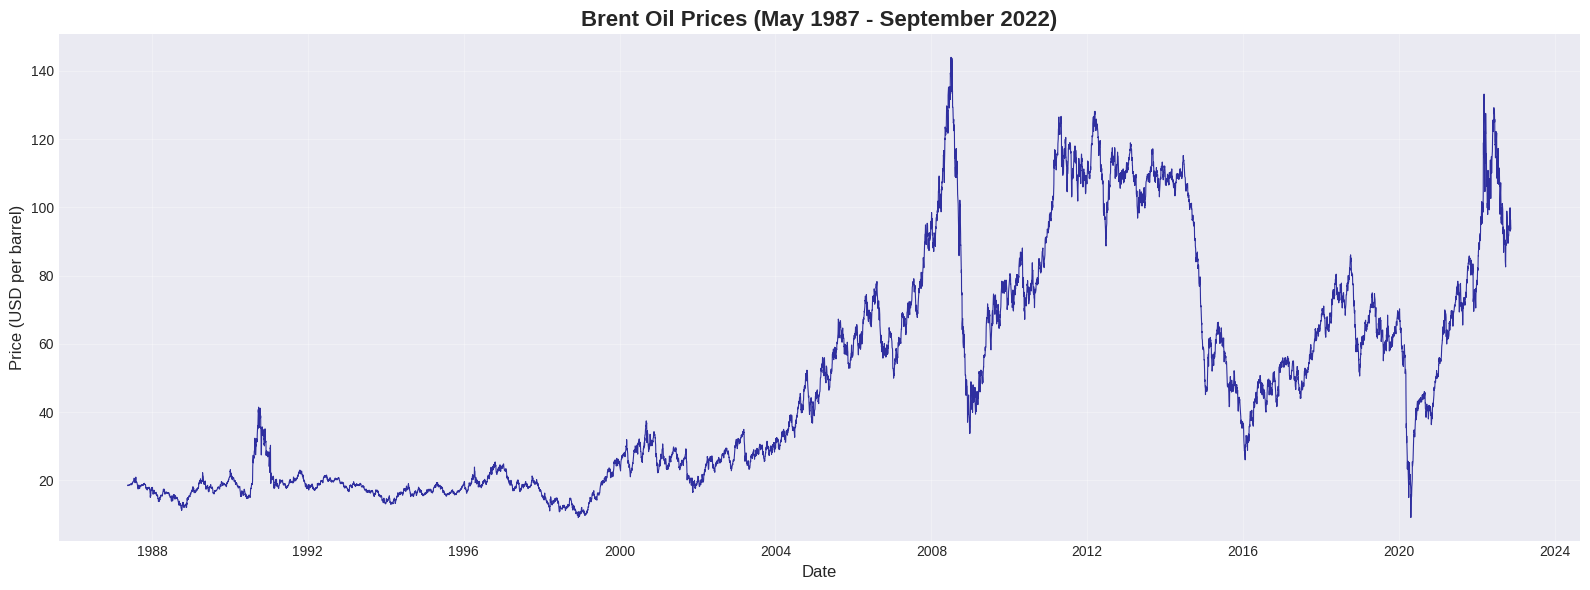


Key observations:
- Maximum price: $143.95 on 2008-07-03
- Minimum price: $9.10 on 1998-12-10
- Mean price: $48.42
- Median price: $38.57


<Figure size 640x480 with 0 Axes>

In [7]:
# Plot historical prices
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df['Date'], df['Price'], linewidth=0.8, color='darkblue', alpha=0.8)
ax.set_title('Brent Oil Prices (May 1987 - September 2022)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD per barrel)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"- Maximum price: ${df['Price'].max():.2f} on {df.loc[df['Price'].idxmax(), 'Date'].date()}")
print(f"- Minimum price: ${df['Price'].min():.2f} on {df.loc[df['Price'].idxmin(), 'Date'].date()}")
print(f"- Mean price: ${df['Price'].mean():.2f}")
print(f"- Median price: ${df['Price'].median():.2f}")
plt.savefig('../results/figures/fig_brent_prices_full.png', dpi=300, bbox_inches='tight')


### 2.1 Recent Decade Focus (2012-2022)
Analysis will focus on the past decade to align with event data.

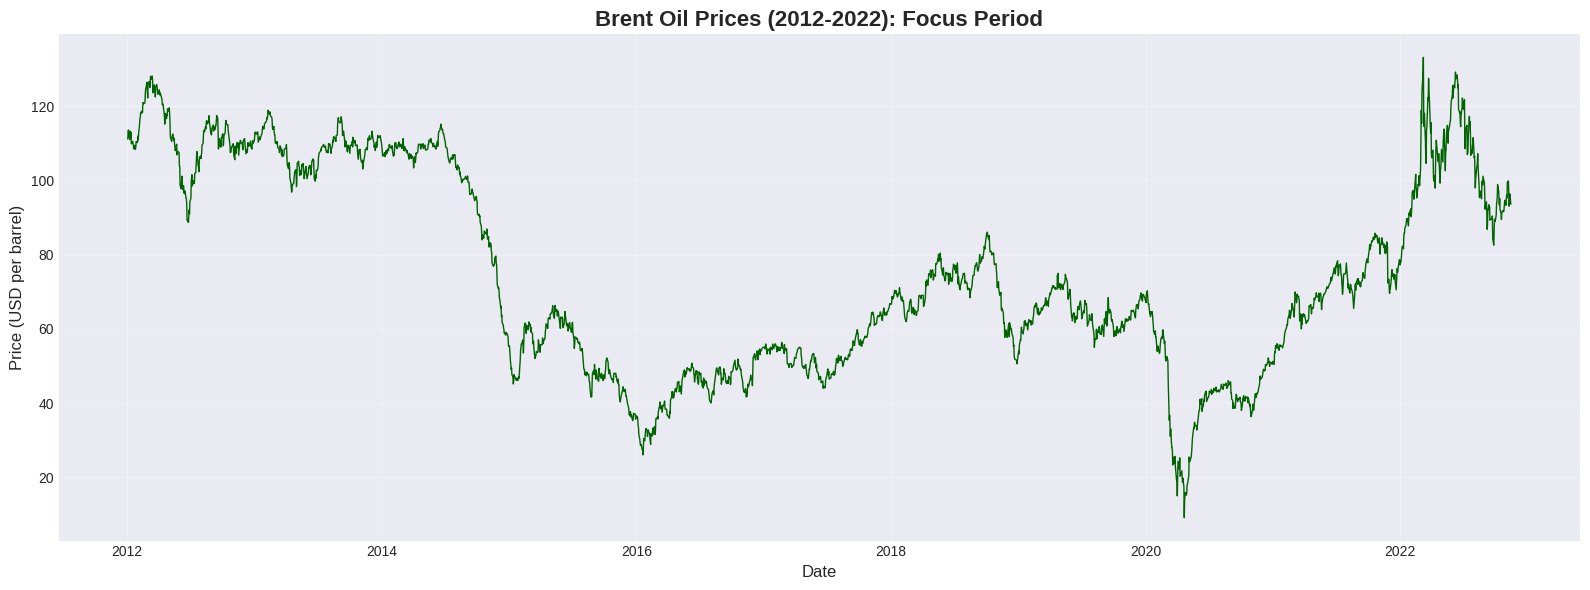

Recent data shape: (2760, 2)
Recent price range: $9.12 - $133.18


<Figure size 640x480 with 0 Axes>

In [9]:
# Filter to recent decade
df_recent = df[df['Date'] >= '2012-01-01'].copy()

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_recent['Date'], df_recent['Price'], linewidth=1, color='darkgreen')
ax.set_title('Brent Oil Prices (2012-2022): Focus Period', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD per barrel)', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Recent data shape: {df_recent.shape}")
print(f"Recent price range: ${df_recent['Price'].min():.2f} - ${df_recent['Price'].max():.2f}")
plt.savefig('../results/figures/fig_brent_prices_2012_2022.png', dpi=300, bbox_inches='tight')


## 3. Log Returns Analysis

In [10]:
# Calculate log returns
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))
df_recent['Log_Return'] = np.log(df_recent['Price'] / df_recent['Price'].shift(1))

# Remove NaN from first row
df = df.dropna()
df_recent = df_recent.dropna()

print("Log returns summary (full data):")
print(df['Log_Return'].describe())
print("\nLog returns summary (2012-2022):")
print(df_recent['Log_Return'].describe())

Log returns summary (full data):
count    9010.000000
mean        0.000179
std         0.025532
min        -0.643699
25%        -0.011154
50%         0.000402
75%         0.012127
max         0.412023
Name: Log_Return, dtype: float64

Log returns summary (2012-2022):
count    2759.000000
mean       -0.000062
std         0.029486
min        -0.643699
25%        -0.010535
50%         0.000603
75%         0.011434
max         0.412023
Name: Log_Return, dtype: float64


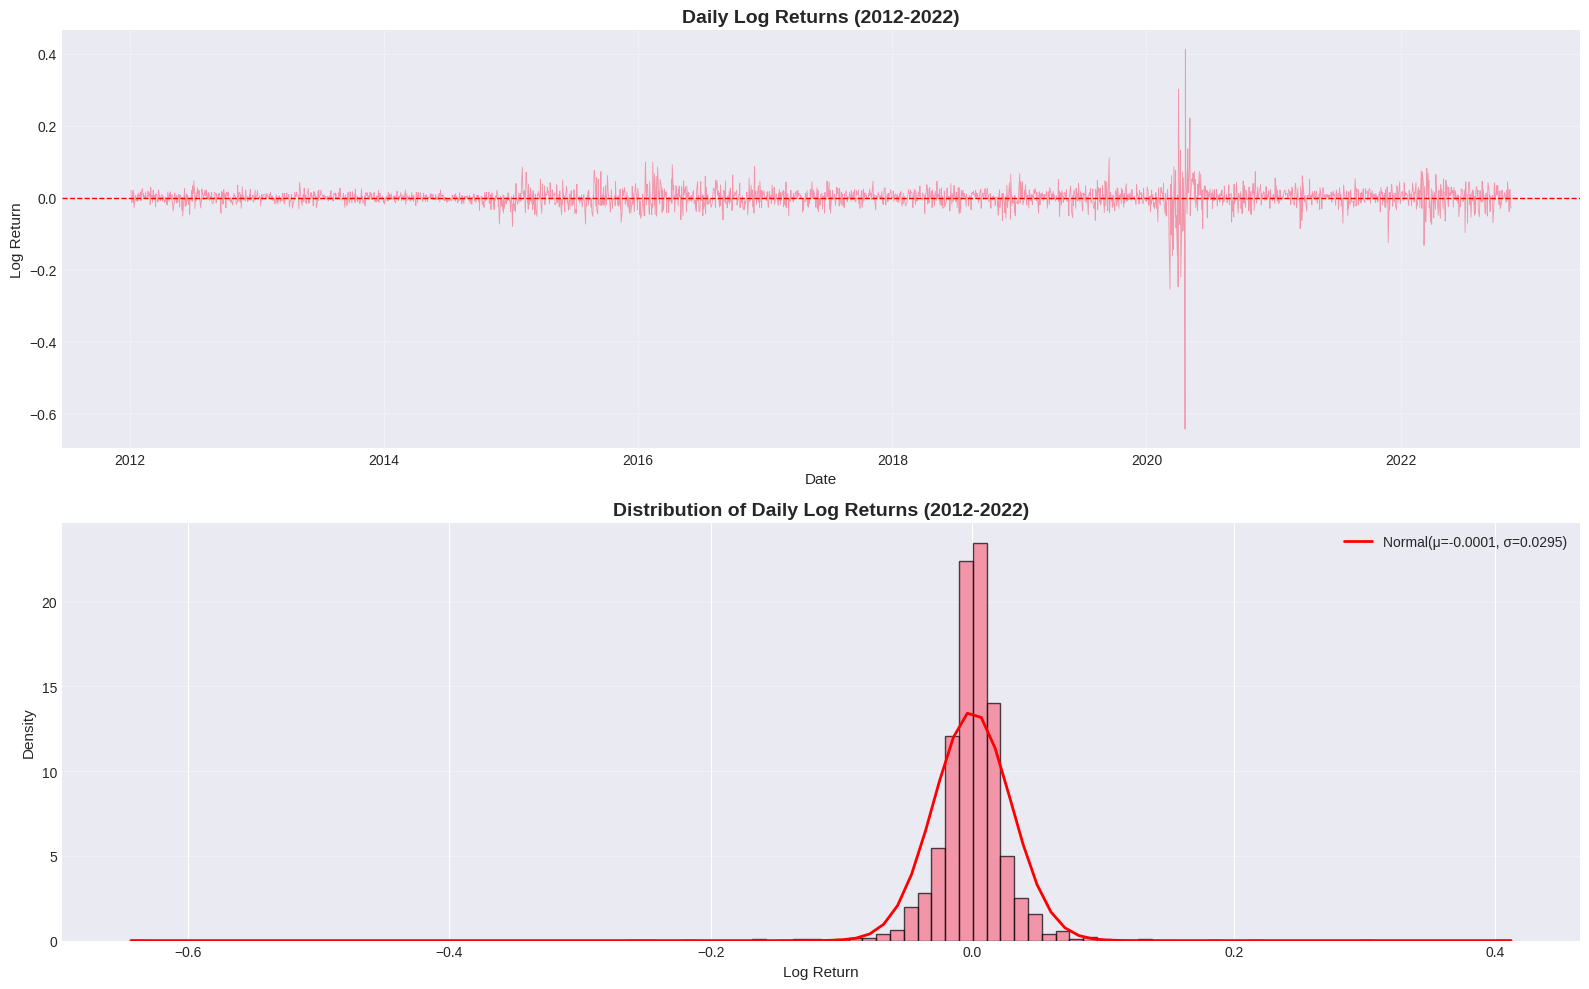

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot log returns
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Time series of log returns
axes[0].plot(df_recent['Date'], df_recent['Log_Return'], linewidth=0.6, alpha=0.7)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[0].set_title('Daily Log Returns (2012-2022)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Log Return', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Distribution of log returns
axes[1].hist(df_recent['Log_Return'], bins=100, alpha=0.7, edgecolor='black', density=True)
axes[1].set_title('Distribution of Daily Log Returns (2012-2022)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Log Return', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

# Overlay normal distribution
mu, std = df_recent['Log_Return'].mean(), df_recent['Log_Return'].std()
x = np.linspace(df_recent['Log_Return'].min(), df_recent['Log_Return'].max(), 100)
axes[1].plot(x, stats.norm.pdf(x, mu, std), 'r-', linewidth=2, label=f'Normal(μ={mu:.4f}, σ={std:.4f})')
axes[1].legend()

plt.tight_layout()
plt.show()
plt.savefig('../results/figures/fig_log_returns_analysis.png', dpi=300, bbox_inches='tight')


In [12]:
# Test for normality
statistic, p_value = stats.normaltest(df_recent['Log_Return'])
print(f"Normality test (D'Agostino-Pearson):")
print(f"  Statistic: {statistic:.4f}")
print(f"  P-value: {p_value:.6f}")
if p_value < 0.05:
    print("  Result: Reject normality (p < 0.05) - Returns have fat tails or skewness")
else:
    print("  Result: Cannot reject normality (p >= 0.05)")

# Skewness and kurtosis
skew = stats.skew(df_recent['Log_Return'])
kurt = stats.kurtosis(df_recent['Log_Return'])
print(f"\nSkewness: {skew:.4f} (normal = 0)")
print(f"Kurtosis: {kurt:.4f} (normal = 0, higher = fatter tails)")

Normality test (D'Agostino-Pearson):
  Statistic: 2341.1373
  P-value: 0.000000
  Result: Reject normality (p < 0.05) - Returns have fat tails or skewness

Skewness: -2.9217 (normal = 0)
Kurtosis: 107.2030 (normal = 0, higher = fatter tails)


## 4. Volatility Analysis

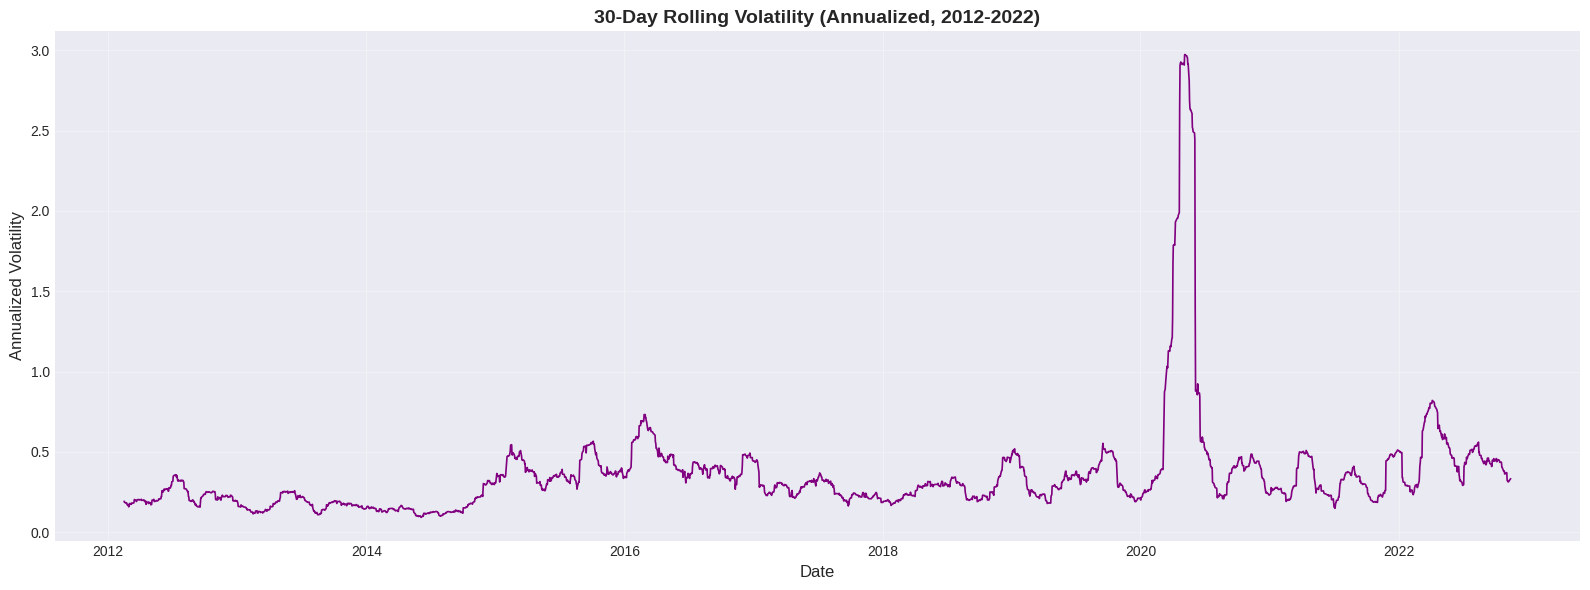


Volatility clustering observation:
Periods of high volatility tend to cluster together, indicating regime changes.


<Figure size 640x480 with 0 Axes>

In [14]:
# Rolling volatility (30-day window)
window = 30
df_recent['Rolling_Volatility'] = df_recent['Log_Return'].rolling(window=window).std() * np.sqrt(252)  # Annualized

fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_recent['Date'], df_recent['Rolling_Volatility'], linewidth=1.2, color='purple')
ax.set_title(f'{window}-Day Rolling Volatility (Annualized, 2012-2022)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Annualized Volatility', fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('../results/figures/fig_rolling_volatility.png', dpi=300, bbox_inches='tight')

print("\nVolatility clustering observation:")
print("Periods of high volatility tend to cluster together, indicating regime changes.")

## 5. Stationarity Testing

In [15]:
# Augmented Dickey-Fuller test on prices
def adf_test(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.6f}")
    print(f"  P-value: {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    if result[1] < 0.05:
        print(f"  Result: Reject null - Series is STATIONARY (p < 0.05)")
    else:
        print(f"  Result: Cannot reject null - Series is NON-STATIONARY (p >= 0.05)")
    return result

print("=" * 60)
print("AUGMENTED DICKEY-FULLER TEST")
print("Null Hypothesis: Series has a unit root (non-stationary)")
print("=" * 60)

adf_price = adf_test(df_recent['Price'], "Price Level")
adf_returns = adf_test(df_recent['Log_Return'], "Log Returns")

AUGMENTED DICKEY-FULLER TEST
Null Hypothesis: Series has a unit root (non-stationary)

Price Level:
  ADF Statistic: -2.219728
  P-value: 0.199164
  Critical Values:
    1%: -3.4327
    5%: -2.8626
    10%: -2.5673
  Result: Cannot reject null - Series is NON-STATIONARY (p >= 0.05)

Log Returns:
  ADF Statistic: -8.973436
  P-value: 0.000000
  Critical Values:
    1%: -3.4327
    5%: -2.8626
    10%: -2.5673
  Result: Reject null - Series is STATIONARY (p < 0.05)


In [16]:
# KPSS test
def kpss_test(series, name):
    result = kpss(series.dropna(), regression='c', nlags='auto')
    print(f"\n{name}:")
    print(f"  KPSS Statistic: {result[0]:.6f}")
    print(f"  P-value: {result[1]:.6f}")
    print(f"  Critical Values:")
    for key, value in result[3].items():
        print(f"    {key}: {value:.4f}")
    if result[1] < 0.05:
        print(f"  Result: Reject null - Series is NON-STATIONARY (p < 0.05)")
    else:
        print(f"  Result: Cannot reject null - Series is STATIONARY (p >= 0.05)")
    return result

print("\n" + "=" * 60)
print("KPSS TEST")
print("Null Hypothesis: Series is stationary")
print("=" * 60)

kpss_price = kpss_test(df_recent['Price'], "Price Level")
kpss_returns = kpss_test(df_recent['Log_Return'], "Log Returns")


KPSS TEST
Null Hypothesis: Series is stationary

Price Level:
  KPSS Statistic: 2.378829
  P-value: 0.010000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Result: Reject null - Series is NON-STATIONARY (p < 0.05)

Log Returns:
  KPSS Statistic: 0.120968
  P-value: 0.100000
  Critical Values:
    10%: 0.3470
    5%: 0.4630
    2.5%: 0.5740
    1%: 0.7390
  Result: Cannot reject null - Series is STATIONARY (p >= 0.05)


## 6. Autocorrelation Analysis

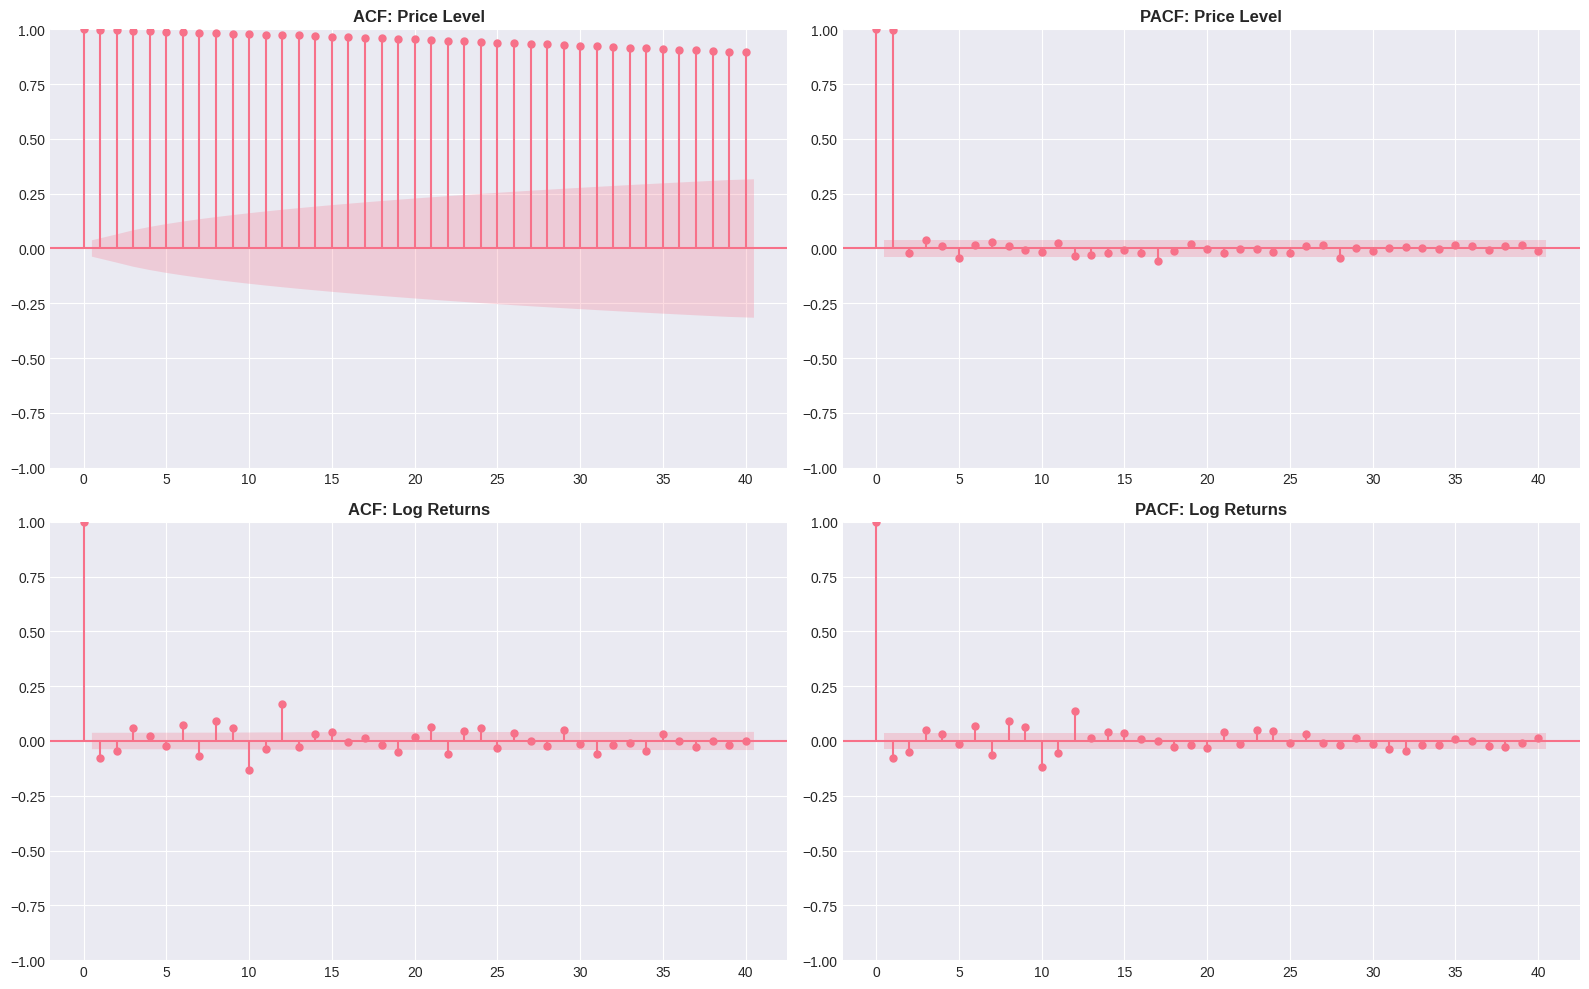


Interpretation:
- Price levels show strong autocorrelation (non-stationary behavior)
- Log returns show minimal autocorrelation (closer to white noise)


<Figure size 640x480 with 0 Axes>

In [18]:
# Autocorrelation and partial autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ACF and PACF for prices
plot_acf(df_recent['Price'].dropna(), lags=40, ax=axes[0, 0])
axes[0, 0].set_title('ACF: Price Level', fontsize=12, fontweight='bold')
plot_pacf(df_recent['Price'].dropna(), lags=40, ax=axes[0, 1])
axes[0, 1].set_title('PACF: Price Level', fontsize=12, fontweight='bold')

# ACF and PACF for log returns
plot_acf(df_recent['Log_Return'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: Log Returns', fontsize=12, fontweight='bold')
plot_pacf(df_recent['Log_Return'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF: Log Returns', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('../results/figures/fig_autocorrelation.png', dpi=300, bbox_inches='tight')


print("\nInterpretation:")
print("- Price levels show strong autocorrelation (non-stationary behavior)")
print("- Log returns show minimal autocorrelation (closer to white noise)")

## 7. Trend Analysis with Moving Averages

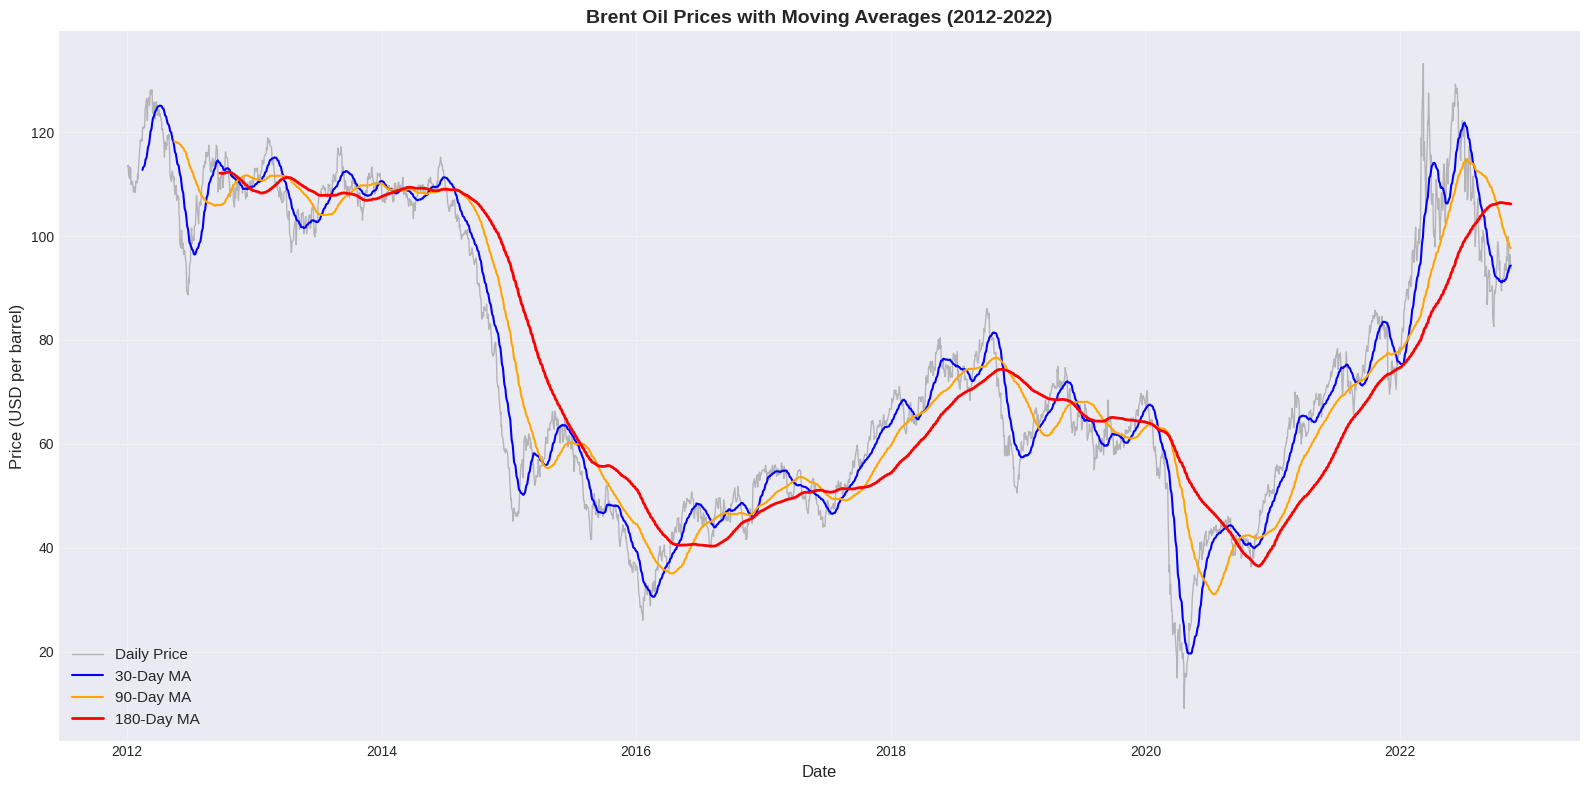

<Figure size 640x480 with 0 Axes>

In [19]:
# Calculate moving averages
df_recent['MA_30'] = df_recent['Price'].rolling(window=30).mean()
df_recent['MA_90'] = df_recent['Price'].rolling(window=90).mean()
df_recent['MA_180'] = df_recent['Price'].rolling(window=180).mean()

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df_recent['Date'], df_recent['Price'], linewidth=1, alpha=0.5, label='Daily Price', color='gray')
ax.plot(df_recent['Date'], df_recent['MA_30'], linewidth=1.5, label='30-Day MA', color='blue')
ax.plot(df_recent['Date'], df_recent['MA_90'], linewidth=1.5, label='90-Day MA', color='orange')
ax.plot(df_recent['Date'], df_recent['MA_180'], linewidth=2, label='180-Day MA', color='red')
ax.set_title('Brent Oil Prices with Moving Averages (2012-2022)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD per barrel)', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('../results/figures/fig_moving_averages.png', dpi=300, bbox_inches='tight')


## 8. Summary of Findings

### Key Time Series Properties:

1. **Trend**:
   - Brent oil prices exhibit clear long-term trends and regime changes
   - Multiple periods of sustained price levels followed by sharp transitions
   - Visual evidence of structural breaks aligning with major geopolitical events

2. **Stationarity**:
   - **Price levels**: Non-stationary (confirmed by ADF and KPSS tests)
   - **Log returns**: Stationary (suitable for statistical modeling)
   - Implication: Work with log returns for change point analysis

3. **Volatility**:
   - Clear volatility clustering - periods of high/low volatility persist
   - Recent decade shows multiple volatility regimes
   - Suggests time-varying variance may be important in modeling

4. **Distribution**:
   - Log returns are approximately normal but with:
     - Slight negative skewness
     - Excess kurtosis (fat tails)
   - Implication: May need Student's t-distribution instead of normal

5. **Autocorrelation**:
   - Price levels: Strong autocorrelation
   - Log returns: Minimal autocorrelation (weak serial dependence)
   - Supports change point modeling approach

### Modeling Implications:

✅ **Recommended Approach**:
- Use log returns as the primary variable for change point detection
- Model mean shifts (regime changes in average returns)
- Consider variance changes if extending the model
- Bayesian methods are well-suited given non-normality

✅ **Model Justification**:
- Evidence of discrete regime changes supports change point framework
- Stationarity within regimes allows for parametric modeling
- Volatility clustering suggests multiple change points may exist

⚠️ **Limitations to Document**:
- Fat tails in returns may affect parameter estimates
- Volatility clustering not explicitly modeled in simple change point models
- External factors (not in data) clearly drive regime changes

## 9. Next Steps

1. Load and visualize geopolitical events timeline
2. Build Bayesian change point model in PyMC
3. Detect change points and quantify uncertainty
4. Associate detected changes with events from our compiled dataset
5. Quantify impact of events on price behavior

In [20]:

desc_stats = pd.DataFrame({
    'Metric': ['Mean', 'Median', 'Std Dev', 'Min', 'Max', 'Skewness', 'Kurtosis'],
    'Price_Full': [
        df['Price'].mean(),
        df['Price'].median(),
        df['Price'].std(),
        df['Price'].min(),
        df['Price'].max(),
        stats.skew(df['Price']),
        stats.kurtosis(df['Price'])
    ],
    'LogReturn_2012_2022': [
        df_recent['Log_Return'].mean(),
        df_recent['Log_Return'].median(),
        df_recent['Log_Return'].std(),
        df_recent['Log_Return'].min(),
        df_recent['Log_Return'].max(),
        stats.skew(df_recent['Log_Return']),
        stats.kurtosis(df_recent['Log_Return'])
    ]
})

desc_stats.to_csv('../results/statistics/stat_descriptive_summary.csv', index=False)
print("Statistics saved to results/statistics/stat_descriptive_summary.csv")


Statistics saved to results/statistics/stat_descriptive_summary.csv


In [21]:
# Save test results
test_results = pd.DataFrame({
    'Test': ['ADF (Price)', 'ADF (Returns)', 'KPSS (Price)', 'KPSS (Returns)'],
    'Statistic': [adf_price[0], adf_returns[0], kpss_price[0], kpss_returns[0]],
    'P_Value': [adf_price[1], adf_returns[1], kpss_price[1], kpss_returns[1]],
    'Conclusion': [
        'Non-stationary' if adf_price[1] >= 0.05 else 'Stationary',
        'Non-stationary' if adf_returns[1] >= 0.05 else 'Stationary',
        'Non-stationary' if kpss_price[1] < 0.05 else 'Stationary',
        'Non-stationary' if kpss_returns[1] < 0.05 else 'Stationary'
    ]
})

test_results.to_csv('../results/statistics/stat_stationarity_tests.csv', index=False)
print("Test results saved to results/statistics/stat_stationarity_tests.csv")


Test results saved to results/statistics/stat_stationarity_tests.csv
